In [97]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import attr
import alphashape
import shapely.geometry
import skimage.morphology
import bayes_opt as bo

from utils import angle_to_rgb, get_colored_difference_image
from gui_config import RunConfiguration
from gui_utils import load_and_preprocess_feature_map, get_padded_moving_and_static, run_config
from bcpd_wrapper import run_bayesian_coherent_point_drift as run_bcpd

from gradient_directions import get_main_gradient_angles_and_intervals, plot_binary_assignments, plot_gradients_as_arrows
from distance_transform import get_binary_assignments_from_gabor
from displacement import estimate_dense_warp_field, Correspondences
from methods import apply_transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


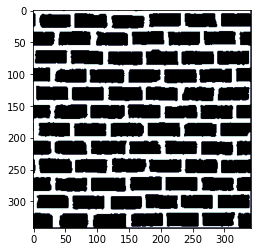

In [2]:
config = RunConfiguration(
    feature_map_path="blue_floor_tiles_01.png",
    downscale_factor=3,
    patch_position=900,
    filter_method="gabor",
    gabor_filter_sigma=0.5,
    response_cutoff_threshold=0.5,
    centroid_method="histogram clustering",
    kde_rho=0.8,
    assignment_type="binary",
    reduce_boundary_weights=True,
    weight_correspondence_angles=True,
    transform_type="dense",
    rbf_type="linear",
    smoothness=3000,
    num_iterations=30,
    num_dct_coeffs=100
)

feature_map = load_and_preprocess_feature_map(Path("data/feature_maps") / config.feature_map_path, config.downscale_factor)
plt.imshow(feature_map, cmap="bone")

In [3]:
result_obj = run_config(config, tqdm(total=config.num_iterations))

C:\Users\leifv\Uni\cglab\gui_utils.py:138: UserWarning: No explicit patch slices are given. run_config will use find_promising_patch_pairs with the currently configured patch size, stride and padding size, which is slow and may lead to inconsistent results. Consider passing a config with explicit values for 'moving_slices' and 'static_slices'.
  warnings.warn("No explicit patch slices are given. run_config will use "
 73%|█████████████████████████████████████████████████████▋                    | 10296/14196 [00:01<00:00, 6872.89it/s]
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


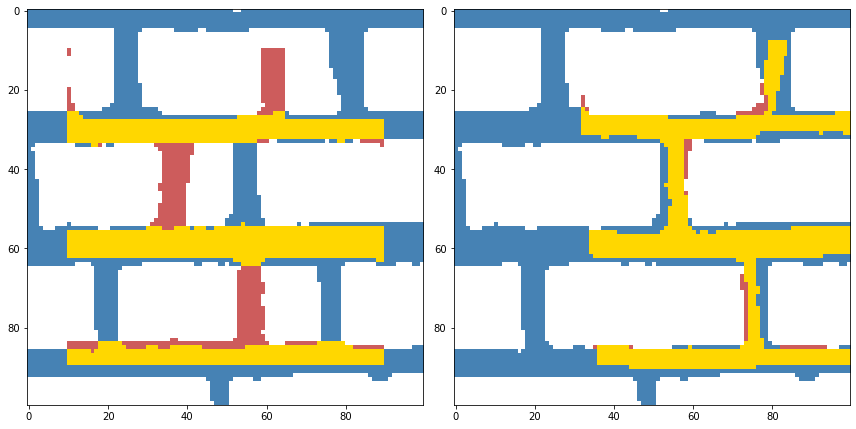

In [17]:
_, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(get_colored_difference_image(moving=result_obj.moving, static=result_obj.static))
axs[1].imshow(get_colored_difference_image(moving=result_obj.warped_moving[-1], static=result_obj.static))

plt.tight_layout()

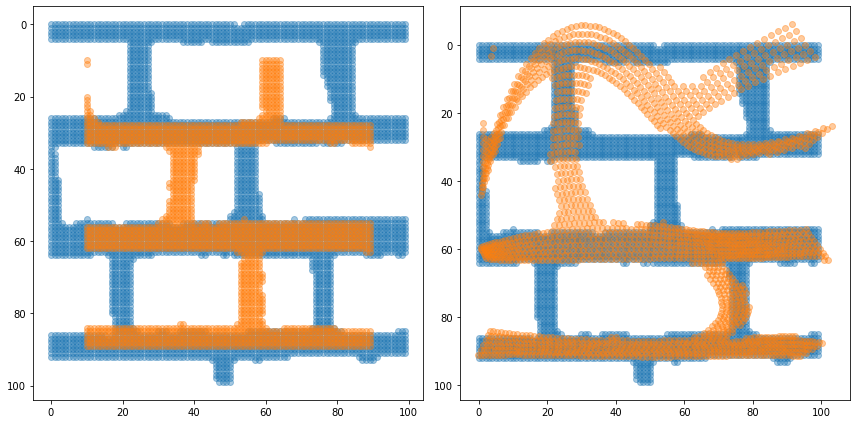

In [22]:
from skimage.morphology import thin

moving_points = np.argwhere(result_obj.moving)
static_points = np.argwhere(result_obj.static)
# moving_points = np.argwhere(thin(result_obj.moving))
# static_points = np.argwhere(thin(result_obj.static))

y = run_bcpd(static_points, moving_points, A=True, lamb=1)

_, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[0].scatter(moving_points[:,1], moving_points[:,0], alpha=0.4)
axs[0].invert_yaxis()

axs[1].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[1].scatter(y[:,1], y[:,0], alpha=0.4)
axs[1].invert_yaxis()

plt.tight_layout()

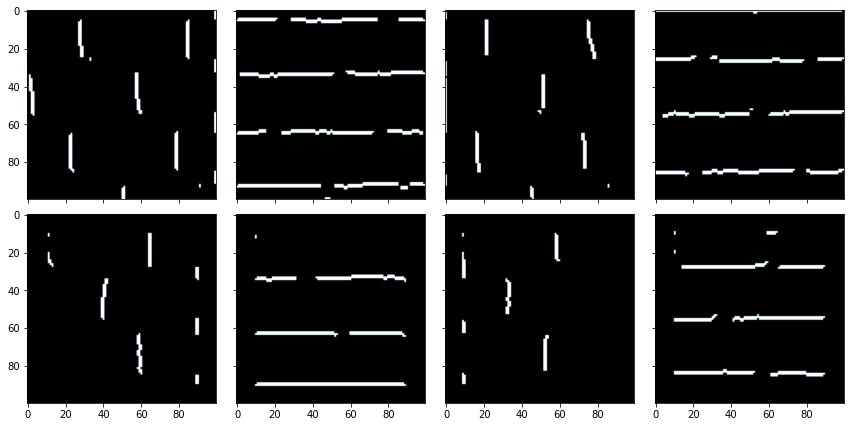

In [6]:
centroids, intervals = get_main_gradient_angles_and_intervals(result_obj.static, rho=config.kde_rho)
static_assignments = get_binary_assignments_from_gabor(result_obj.static, centroids, intervals,
                                                       sigma=config.gabor_filter_sigma,
                                                       threshold=config.response_cutoff_threshold)
moving_assignments = get_binary_assignments_from_gabor(result_obj.moving, centroids, intervals,
                                                       sigma=config.gabor_filter_sigma,
                                                       threshold=config.response_cutoff_threshold)

_, axs = plt.subplots(2,4,figsize=(12,6), sharex=True, sharey=True)

for i, (st_assignment, mv_assignment) in enumerate(zip(static_assignments, moving_assignments)):
    axs[0,i].imshow(st_assignment, cmap='bone')
    axs[1,i].imshow(mv_assignment, cmap='bone')
    
plt.tight_layout()

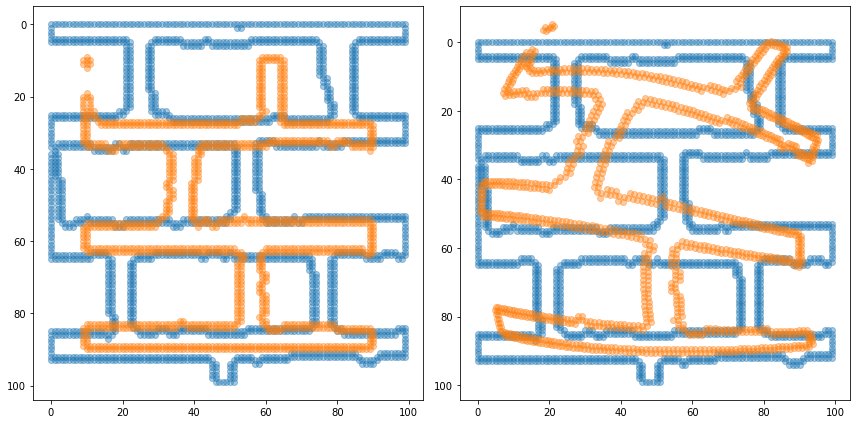

In [31]:
static_edges = static_assignments.sum(axis=0)
moving_edges = moving_assignments.sum(axis=0)

moving_points = np.argwhere(moving_edges)
static_points = np.argwhere(static_edges)

y = run_bcpd(static_points, moving_points, A=True, lamb=10)

_, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[0].scatter(moving_points[:,1], moving_points[:,0], alpha=0.4)
axs[0].invert_yaxis()

axs[1].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[1].scatter(y[:,1], y[:,0], alpha=0.4)
axs[1].invert_yaxis()

plt.tight_layout()

In [7]:
common_config = RunConfiguration(
    filter_method='gabor',
    gabor_filter_sigma=0.5,
    response_cutoff_threshold=0.5,
    centroid_method='histogram clustering',
    kde_rho=0.8,
    assignment_type='binary',
    num_iterations=30,
    reduce_boundary_weights=True,
    transform_type='dense',
    rbf_type='linear',
    smoothness=3000,
    num_dct_coeffs=4
)

def merge_configs(*configs, **additional_params):
    conf = attr.asdict(configs[0])
    for c in configs[1:]:
        conf.update(attr.asdict(c, filter=lambda _,val: val is not None))
    conf.update(additional_params)
    return RunConfiguration(**conf)

feature_map_dir = Path("data/feature_maps")
texture_dir = Path("data/textures")
feature_map_paths = ["blue_floor_tiles_01.png",
                     "brick_4.png",
                     "cobblestone_floor_03.png",
                     "floor_pattern_02.png"]

In [8]:
all_origins = np.zeros((4,32), dtype=np.int)

all_origins[0] = np.array([537, 126, 238,  41, 236, 200, 649, 708, 287, 224, 281, 393, 196,
                           275, 443, 330,  48, 102, 367, 337, 823, 756, 141, 701,  94, 392,
                           503, 347, 543, 705, 816, 144])

all_origins[1] = np.array([ 15, 142, 308, 205, 322, 195, 308, 255, 362, 230, 353, 217, 182,
                            59,  24,  12, 155, 311, 361,  47, 339, 320, 186, 110, 298, 256,
                           238, 301,  17, 190,  10, 207])

all_origins[2] = np.array([ 64,   4,  44,  87,  27, 147, 169, 110,  15, 123,  95, 218, 113,
                            26,  91, 151,  20,  38, 124, 227, 155, 226, 228, 187, 239, 177,
                            39, 116,  18, 207,   13,  70])

all_origins[3] = np.array([135,  89,  77,  74, 114, 129,  31,  14,  52,  79,  24,  38, 118,
                            74,  68,  29, 106,  71, 114, 123,  63,  50,  92,  37,  89, 101,
                           144,  10, 122,  62,  33,  17])

all_origins = all_origins.reshape(4,4,2,2,2)

result_images = np.zeros((64,100,100,3))
i = 0

rerun_config = RunConfiguration(weight_correspondence_angles=True, reduce_boundary_weights=False)


for ds, origins in zip((1,2,3,4), all_origins):
    for path, origins_list in zip(feature_map_paths, origins):
        for (so, to) in origins_list:
            s_slices = (slice(so[0],so[0]+80), slice(so[1],so[1]+80))
            t_slices = (slice(to[0],to[0]+80), slice(to[1],to[1]+80))
            
            c = RunConfiguration(feature_map_path=path, moving_slices=s_slices, static_slices=t_slices, downscale_factor=ds)
            result_obj = run_config(merge_configs(common_config, c), pbar=tqdm(desc=f"{i}",
                                                                               total=common_config.num_iterations))
            
            # rerun if energy does not improve significantly
            if 4/5 * result_obj.results[0].energy < result_obj.results[-1].energy:
                result_obj = run_config(merge_configs(common_config, c, rerun_config),
                                        pbar=tqdm(desc=f"{i} again", total=common_config.num_iterations))

            result_images[i] = get_colored_difference_image(moving=result_obj.moving, static=result_obj.static)
            result_images[i+1] = get_colored_difference_image(moving=result_obj.warped_moving[-1], static=result_obj.static)
            i += 2

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


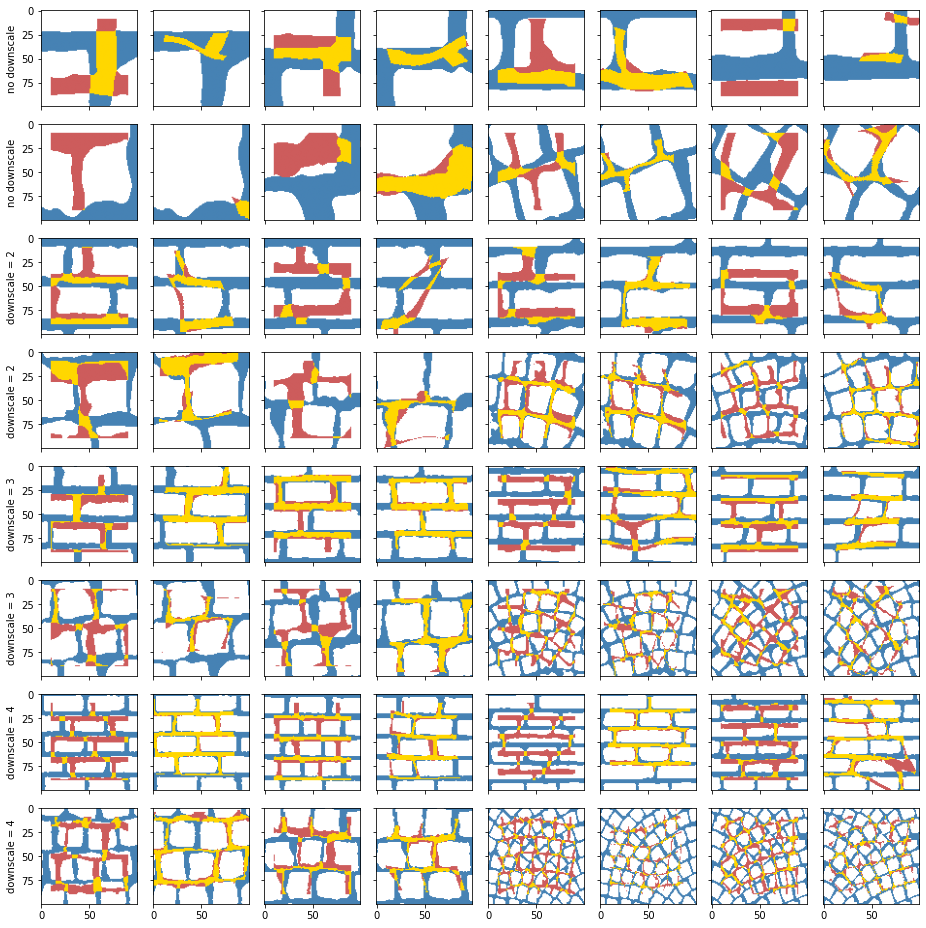

In [9]:
_, axs = plt.subplots(8, 8, figsize=(13,13), sharex=True, sharey=True)
axs_iter = iter(axs.ravel())


for i, (ax, image) in enumerate(zip(axs.ravel(),result_images)):
    if i % 8 == 0:
        if i < 16:
            ax.set_ylabel("no downscale")
        else:
            ax.set_ylabel(f"downscale = {i // 16 + 1}")
    ax.imshow(image)
    #ax.axis('off')
    
plt.tight_layout()

|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.04304  |  0.0      |
|  2        | -0.4383   |  3.7      |
|  3        | -0.4665   |  6.818    |
|  4        | -0.0475   |  1.179    |
|  5        | -0.4665   |  10.0     |
|  6        | -0.04393  |  0.5842   |
|  7        | -0.04449  |  0.8945   |
|  8        | -0.04376  |  0.2273   |
|  9        | -0.04376  |  0.2273   |
|  10       | -0.04376  |  0.2273   |


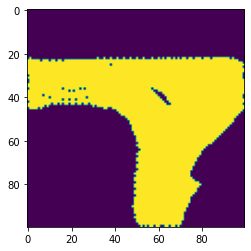

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05047  |  0.0      |
|  2        | -0.2186   |  4.158    |
|  3        | -0.04993  |  0.2373   |
|  4        | -0.2199   |  10.0     |
|  5        | -0.05049  |  1.524    |
|  6        | -0.05049  |  1.004    |
|  7        | -0.05196  |  2.059    |
|  8        | -0.05075  |  0.6221   |
|  9        | -0.05167  |  1.808    |
|  10       | -0.04979  |  1.266    |


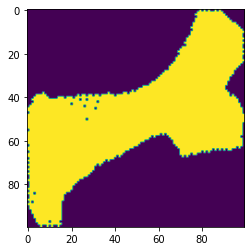

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.04554  |  0.0      |
|  2        | -0.04518  |  1.143    |
|  3        | -0.6882   |  3.585    |
|  4        | -0.6972   |  10.0     |
|  5        | -0.6972   |  6.87     |
|  6        | -0.04464  |  0.5773   |
|  7        | -0.0487   |  1.693    |
|  8        | -0.04641  |  0.2602   |
|  9        | -0.04741  |  1.448    |
|  10       | -0.04377  |  0.8576   |


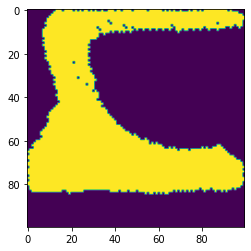

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05107  |  0.0      |
|  2        | -0.5687   |  5.707    |
|  3        | -0.5688   |  8.072    |
|  4        | -0.05498  |  1.747    |
|  5        | -0.0425   |  0.8722   |
|  6        | -0.04611  |  1.258    |
|  7        | -0.2181   |  0.468    |
|  8        | -0.0423   |  0.8724   |
|  9        | -0.2791   |  2.68     |
|  10       | -0.5688   |  10.0     |


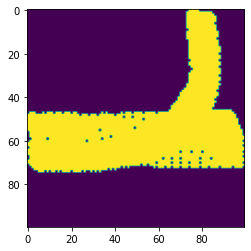

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.0474   |  0.0      |
|  2        | -0.3612   |  7.838    |
|  3        | -0.3592   |  5.484    |
|  4        | -0.04705  |  1.683    |
|  5        | -0.04419  |  0.8509   |
|  6        | -0.04463  |  1.279    |
|  7        | -0.04977  |  0.4142   |
|  8        | -0.3612   |  10.0     |
|  9        | -0.04949  |  2.74     |
|  10       | -0.05376  |  2.314    |


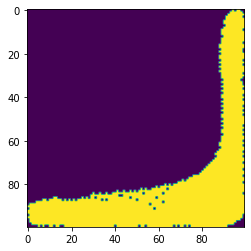

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.04951  |  0.0      |
|  2        | -0.04716  |  2.438    |
|  3        | -0.4874   |  3.932    |
|  4        | -0.5112   |  5.253    |
|  5        | -0.04611  |  1.258    |
|  6        | -0.5122   |  10.0     |
|  7        | -0.5122   |  7.571    |
|  8        | -0.04628  |  1.889    |
|  9        | -0.04517  |  0.5667   |
|  10       | -0.0469   |  2.194    |


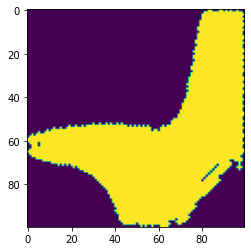

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.04513  |  0.0      |
|  2        | -0.608    |  8.488    |
|  3        | -0.608    |  7.82     |
|  4        | -0.3505   |  2.098    |
|  5        | -0.0514   |  0.4412   |
|  6        | -0.04786  |  0.1951   |
|  7        | -0.04786  |  0.1951   |
|  8        | -0.04786  |  0.003149 |
|  9        | -0.05322  |  1.089    |
|  10       | -0.6072   |  4.876    |


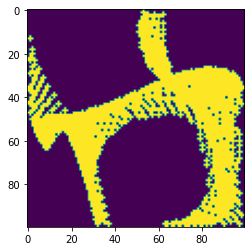

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05362  |  0.0      |
|  2        | -0.3999   |  9.541    |
|  3        | -0.3491   |  3.403    |
|  4        | -0.05374  |  0.007349 |
|  5        | -0.05502  |  0.9085   |
|  6        | -0.3999   |  6.575    |
|  7        | -0.05205  |  0.4905   |
|  8        | -0.05137  |  0.6792   |
|  9        | -0.05169  |  0.632    |
|  10       | -0.05003  |  0.2415   |


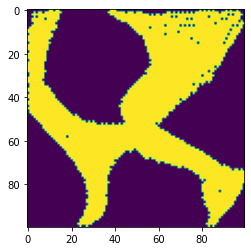

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05181  |  0.0      |
|  2        | -0.4325   |  6.056    |
|  3        | -0.4326   |  6.455    |
|  4        | -0.05602  |  1.61     |
|  5        | -0.4326   |  10.0     |
|  6        | -0.05367  |  0.7963   |
|  7        | -0.3655   |  2.458    |
|  8        | -0.4326   |  8.25     |
|  9        | -0.05795  |  1.235    |
|  10       | -0.4309   |  4.375    |


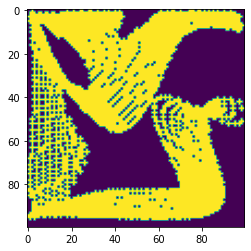

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05411  |  0.0      |
|  2        | -0.5899   |  9.814    |
|  3        | -0.5884   |  4.221    |
|  4        | -0.5789   |  3.051    |
|  5        | -0.05514  |  0.8987   |
|  6        | -0.5899   |  6.984    |
|  7        | -0.05404  |  0.4504   |
|  8        | -0.05588  |  1.342    |
|  9        | -0.05384  |  0.2009   |
|  10       | -0.05571  |  1.152    |


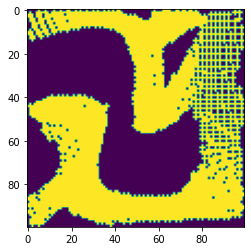

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.06013  |  0.0      |
|  2        | -0.4675   |  9.607    |
|  3        | -0.4675   |  8.735    |
|  4        | -0.2264   |  2.36     |
|  5        | -0.2264   |  2.36     |
|  6        | -0.2264   |  2.36     |
|  7        | -0.2264   |  2.36     |
|  8        | -0.2264   |  2.36     |
|  9        | -0.2264   |  2.36     |
|  10       | -0.2264   |  2.36     |


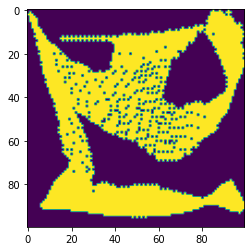

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05637  |  0.0      |
|  2        | -0.4849   |  4.493    |
|  3        | -0.4875   |  5.398    |
|  4        | -0.4879   |  10.0     |
|  5        | -0.05872  |  1.184    |
|  6        | -0.05533  |  0.5902   |
|  7        | -0.2049   |  1.829    |
|  8        | -0.4879   |  7.727    |
|  9        | -0.05699  |  0.9048   |
|  10       | -0.05488  |  0.2555   |


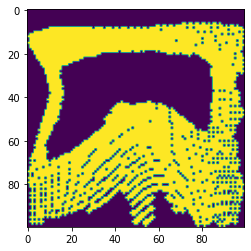

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05276  |  0.0      |
|  2        | -0.3509   |  9.243    |
|  3        | -0.3477   |  4.753    |
|  4        | -0.05138  |  0.7614   |
|  5        | -0.2307   |  1.888    |
|  6        | -0.3509   |  6.972    |
|  7        | -0.05161  |  0.3838   |
|  8        | -0.05208  |  0.5947   |
|  9        | -0.05122  |  0.169    |
|  10       | -0.05542  |  0.9668   |


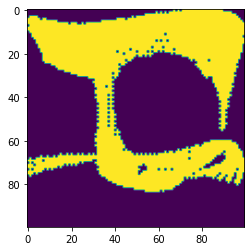

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.04929  |  0.0      |
|  2        | -0.2772   |  6.31     |
|  3        | -0.2734   |  7.805    |
|  4        | -0.05763  |  1.83     |
|  5        | -0.0501   |  0.8697   |
|  6        | -0.0484   |  0.3758   |
|  7        | -0.05012  |  0.2365   |
|  8        | -0.2486   |  3.528    |
|  9        | -0.2772   |  10.0     |
|  10       | -0.05625  |  1.415    |


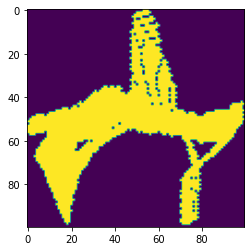

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05709  |  0.0      |
|  2        | -0.2325   |  5.148    |
|  3        | -0.2072   |  2.61     |
|  4        | -0.05731  |  0.1859   |
|  5        | -0.2321   |  10.0     |
|  6        | -0.05938  |  0.8357   |
|  7        | -0.231    |  7.523    |
|  8        | -0.05718  |  0.5565   |
|  9        | -0.0585   |  0.3929   |
|  10       | -0.05976  |  0.6827   |


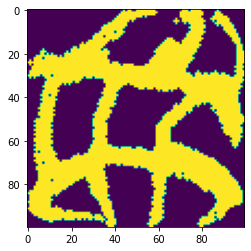

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05976  |  0.0      |
|  2        | -0.2692   |  8.797    |
|  3        | -0.2692   |  6.196    |
|  4        | -0.06021  |  1.901    |
|  5        | -0.05888  |  0.9562   |
|  6        | -0.2337   |  2.826    |
|  7        | -0.2691   |  4.569    |
|  8        | -0.06025  |  1.458    |
|  9        | -0.2712   |  10.0     |
|  10       | -0.05907  |  0.4334   |


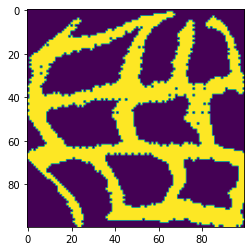

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05625  |  0.0      |
|  2        | -0.05977  |  7.511    |
|  3        | -0.05973  |  6.549    |
|  4        | -0.05538  |  1.78     |
|  5        | -0.0555   |  3.167    |
|  6        | -0.05482  |  2.47     |
|  7        | -0.05962  |  10.0     |
|  8        | -0.05521  |  2.643    |
|  9        | -0.0591   |  4.455    |
|  10       | -0.05417  |  0.8411   |


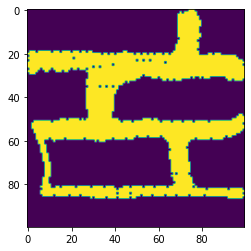

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05556  |  0.0      |
|  2        | -0.2792   |  5.334    |
|  3        | -0.2789   |  4.753    |
|  4        | -0.2784   |  10.0     |
|  5        | -0.2068   |  1.209    |
|  6        | -0.2788   |  7.659    |
|  7        | -0.05654  |  0.3196   |
|  8        | -0.262    |  3.02     |
|  9        | -0.05608  |  0.1569   |
|  10       | -0.05661  |  0.4938   |


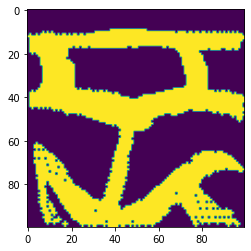

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05106  |  0.0      |
|  2        | -0.0583   |  5.454    |
|  3        | -0.05091  |  0.306    |
|  4        | -0.05879  |  10.0     |
|  5        | -0.05093  |  2.108    |
|  6        | -0.05117  |  1.348    |
|  7        | -0.05081  |  3.153    |
|  8        | -0.05023  |  2.713    |
|  9        | -0.0507   |  2.588    |
|  10       | -0.05881  |  7.704    |


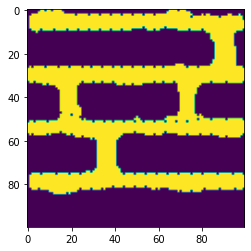

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05244  |  0.0      |
|  2        | -0.05208  |  1.433    |
|  3        | -0.05791  |  5.555    |
|  4        | -0.05844  |  10.0     |
|  5        | -0.0518   |  2.611    |
|  6        | -0.05244  |  2.127    |
|  7        | -0.05602  |  3.676    |
|  8        | -0.05844  |  7.712    |
|  9        | -0.05126  |  0.7049   |
|  10       | -0.0514   |  0.9785   |


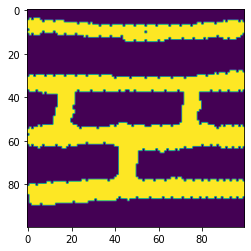

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)


|   iter    |  target   | lamb_pow  |
-------------------------------------


C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|  1        | -0.05584  |  0.0      |
|  2        | -0.2617   |  8.458    |
|  3        | -0.2617   |  6.376    |
|  4        | -0.2051   |  1.892    |
|  5        | -0.2005   |  0.6383   |
|  6        | -0.05465  |  0.005227 |
|  7        | -0.2558   |  4.049    |
|  8        | -0.2616   |  10.0     |
|  9        | -0.05415  |  0.2572   |
|  10       | -0.2297   |  2.873    |


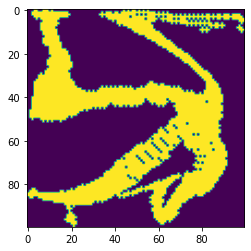

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.0608   |  0.0      |
|  2        | -0.2882   |  9.027    |
|  3        | -0.2882   |  7.906    |
|  4        | -0.2247   |  2.177    |
|  5        | -0.06005  |  0.6548   |
|  6        | -0.2861   |  5.114    |
|  7        | -0.05936  |  0.3318   |
|  8        | -0.06091  |  0.5022   |
|  9        | -0.05516  |  1.141    |
|  10       | -0.2074   |  0.9743   |


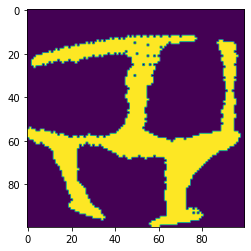

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.06009  |  0.0      |
|  2        | -0.2487   |  7.522    |
|  3        | -0.2287   |  0.902    |
|  4        | -0.06364  |  0.008897 |
|  5        | -0.2473   |  4.194    |
|  6        | -0.2488   |  10.0     |
|  7        | -0.2487   |  2.524    |
|  8        | -0.2476   |  5.855    |
|  9        | -0.2488   |  8.761    |
|  10       | -0.2392   |  1.677    |


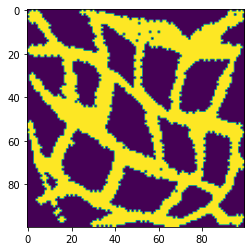

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.06055  |  0.0      |
|  2        | -0.2684   |  1.62     |
|  3        | -0.2699   |  3.757    |
|  4        | -0.06007  |  0.01677  |
|  5        | -0.2692   |  10.0     |
|  6        | -0.2704   |  6.843    |
|  7        | -0.2704   |  8.422    |
|  8        | -0.215    |  0.5369   |
|  9        | -0.2693   |  7.88     |
|  10       | -0.2693   |  5.306    |


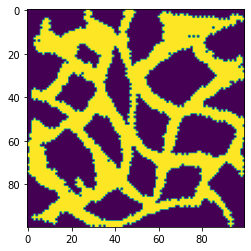

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05512  |  0.0      |
|  2        | -0.05616  |  0.3432   |
|  3        | -0.05175  |  1.685    |
|  4        | -0.05182  |  2.193    |
|  5        | -0.2088   |  3.326    |
|  6        | -0.2176   |  10.0     |
|  7        | -0.2165   |  6.746    |
|  8        | -0.2167   |  8.362    |
|  9        | -0.05246  |  1.025    |
|  10       | -0.05187  |  1.966    |


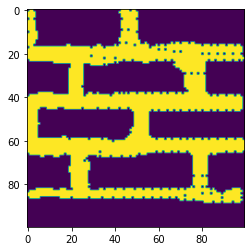

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05896  |  0.0      |
|  2        | -0.2999   |  8.865    |
|  3        | -0.3      |  5.888    |
|  4        | -0.2924   |  1.857    |
|  5        | -0.05945  |  0.000594 |
|  6        | -0.2992   |  3.871    |
|  7        | -0.2791   |  0.5102   |
|  8        | -0.3001   |  7.376    |
|  9        | -0.3001   |  10.0     |
|  10       | -0.2979   |  2.858    |


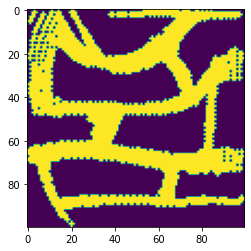

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.2343   |  0.0      |
|  2        | -0.2991   |  8.864    |
|  3        | -0.2995   |  6.954    |
|  4        | -0.2771   |  2.03     |
|  5        | -0.2565   |  0.6372   |
|  6        | -0.2967   |  4.249    |
|  7        | -0.2471   |  0.08194  |
|  8        | -0.2728   |  0.9525   |
|  9        | -0.2546   |  0.398    |
|  10       | -0.2994   |  5.595    |


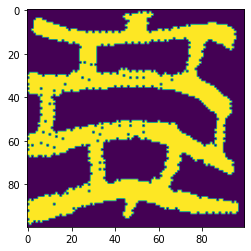

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.0532   |  0.0      |
|  2        | -0.05559  |  4.13     |
|  3        | -0.05702  |  5.705    |
|  4        | -0.04982  |  1.563    |
|  5        | -0.05058  |  2.424    |
|  6        | -0.05755  |  10.0     |
|  7        | -0.05092  |  1.892    |
|  8        | -0.0494   |  0.9131   |
|  9        | -0.05755  |  7.796    |
|  10       | -0.05097  |  3.074    |


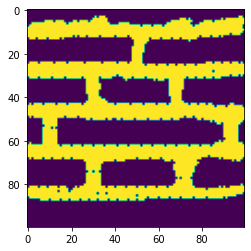

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05583  |  0.0      |
|  2        | -0.2105   |  2.426    |
|  3        | -0.2863   |  7.057    |
|  4        | -0.2812   |  4.542    |
|  5        | -0.0554   |  0.4596   |
|  6        | -0.2863   |  10.0     |
|  7        | -0.05561  |  0.2343   |
|  8        | -0.05615  |  0.8814   |
|  9        | -0.05585  |  0.6998   |
|  10       | -0.05489  |  0.3597   |


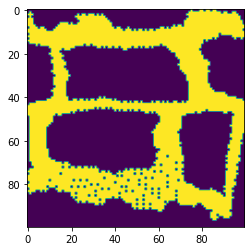

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.05561  |  0.0      |
|  2        | -0.3207   |  2.823    |
|  3        | -0.3434   |  4.406    |
|  4        | -0.3479   |  10.0     |
|  5        | -0.0592   |  0.8715   |
|  6        | -0.348    |  7.153    |
|  7        | -0.0557   |  0.4283   |
|  8        | -0.05883  |  0.6472   |
|  9        | -0.2667   |  1.386    |
|  10       | -0.3479   |  8.576    |


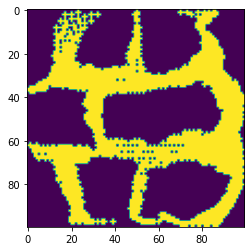

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.0644   |  0.0      |
|  2        | -0.2018   |  5.924    |
|  3        | -0.06886  |  6.471    |
|  4        | -0.06886  |  6.472    |
|  5        | -0.06482  |  0.4513   |
|  6        | -0.06614  |  0.9953   |
|  7        | -0.06747  |  1.555    |
|  8        | -0.06897  |  2.136    |
|  9        | -0.06846  |  2.733    |
|  10       | -0.06871  |  3.319    |


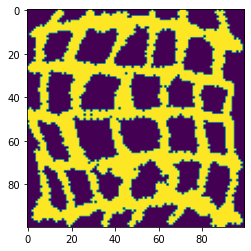

C:\Users\leifv\Uni\cglab\gui_utils.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moving = np.pad(feature_map[moving_slices], conf.PADDING_SIZE)
C:\Users\leifv\Uni\cglab\gui_utils.py:212: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  warnings.warn("The config and results will not be saved as a file, "


|   iter    |  target   | lamb_pow  |
-------------------------------------
|  1        | -0.06529  |  0.0      |
|  2        | -0.206    |  7.289    |
|  3        | -0.2058   |  3.922    |
|  4        | -0.06525  |  1.126    |
|  5        | -0.2059   |  10.0     |
|  6        | -0.06464  |  0.5683   |
|  7        | -0.06572  |  1.716    |
|  8        | -0.06576  |  1.456    |
|  9        | -0.06531  |  0.2612   |
|  10       | -0.06438  |  0.824    |


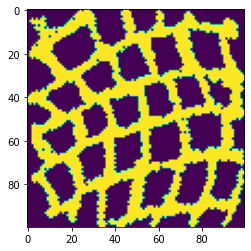

In [114]:
def get_bcpd_result(moving, static):
    moving_points = np.argwhere(moving)
    static_points = np.argwhere(static)

    def get_score(lamb_pow):
        _, info = run_bcpd(static_points, moving_points, A=True, return_info=True, lamb=10 ** lamb_pow)
        return -info['sigma']
    
    opt = bo.BayesianOptimization(f=get_score, pbounds={'lamb_pow': (0, 10)})
    opt.probe(params=dict(lamb_pow=0))
    opt.maximize(init_points=2, n_iter=7)
    
    best_lamb = 10 ** opt.max['params']['lamb_pow']
    y, info = run_bcpd(static_points, moving_points, A=True, output='y', return_info=True, lamb=best_lamb)
    
    warped = np.zeros_like(moving)
    
    points = np.round(y).astype(np.int)
    mask = np.all((points > 0) & (points < 99), axis=1)
    points = points[mask,:]

    warped[points[:,0], points[:,1]] = 1
    warped[points[:,0]+1, points[:,1]] = 1
    warped[points[:,0]-1, points[:,1]] = 1
    warped[points[:,0], points[:,1]+1] = 1
    warped[points[:,0], points[:,1]-1] = 1
    
    plt.imshow(warped)
    plt.show()
    
    return warped

    
i = 0

pbar = tqdm(total=32)

for ds, origins in zip((1,2,3,4), all_origins):
    for path, origins_list in zip(feature_map_paths, origins):
        for (so, to) in origins_list:
            s_slices = (slice(so[0],so[0]+80), slice(so[1],so[1]+80))
            t_slices = (slice(to[0],to[0]+80), slice(to[1],to[1]+80))
            
            c = RunConfiguration(feature_map_path=path, moving_slices=s_slices, static_slices=t_slices, downscale_factor=ds)
            # we only do this to get moving and static
            result_obj = run_config(merge_configs(common_config, c, num_iterations=1), pbar=None)
            
            warped = get_bcpd_result(result_obj.moving, result_obj.static)
            
            result_images[i] = get_colored_difference_image(moving=result_obj.moving, static=result_obj.static)
            result_images[i+1] = get_colored_difference_image(moving=warped, static=result_obj.static)
            i += 2
            pbar.update(1)
            
pbar.close()

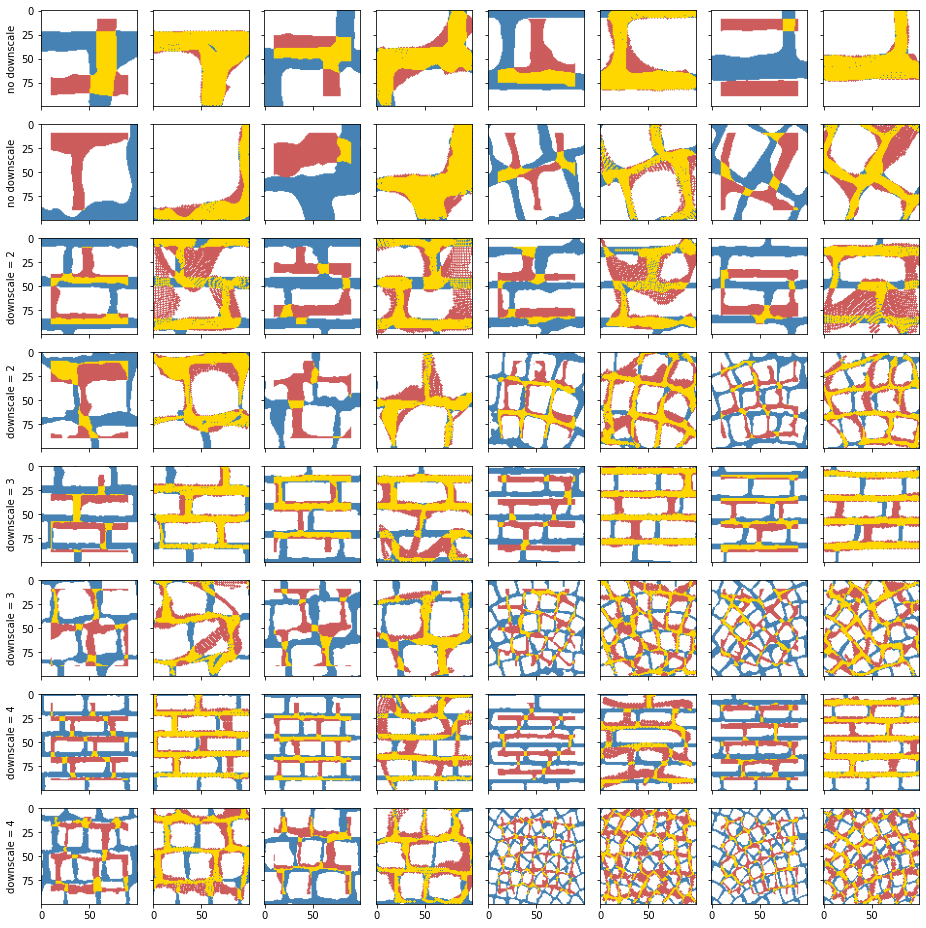

In [115]:
_, axs = plt.subplots(8, 8, figsize=(13,13), sharex=True, sharey=True)
axs_iter = iter(axs.ravel())


for i, (ax, image) in enumerate(zip(axs.ravel(),result_images)):
    if i % 8 == 0:
        if i < 16:
            ax.set_ylabel("no downscale")
        else:
            ax.set_ylabel(f"downscale = {i // 16 + 1}")
    ax.imshow(image)
    #ax.axis('off')
    
plt.tight_layout()